Example 1: Comparing KRAS Proteins
===================================


In [10]:
import os

import numpy as np
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import sklearn.metrics

from GWProt import GW_protein, stress_comparison, pymol_protein_viewer


KRAS (Kirsten Rat Sarcoma) is a signalling protein involved in cell proliferation. In its off state it is bound to guanosine diphosphate (GDP). In its on state it is bound to guanosine triphosphate (GTP) and activates effector proteins which can bind to two flexible switch regions. Certain mutant forms of KRAS keep it in its on state which can cause proliferation, causing multiple types of cancer. Thus mutant forms of KRAS are potential targets for drugs to treat the cancers they cause.

In this example we consider 54 KRAS proteins and will compare them with ``GWProt``. We will group them using the GW distance and see how that corresponds to different positions of the switch regions. We will also see how the stresses capture the switch regions.


This dataset consists of experimentally determined PDB files of KRAS retreived from [RCSB](https://www.rcsb.org), including both wild type and several missense mutants. Ligands, ions, and small molecules including potential drug candidates have been removed for clarity. All proteins were truncated to amino acids 2-162 in the [canonical sequence](https://www.uniprot.org/uniprotkb/P01116/entry#sequences) as some had missing data beyond that range. Files with multiple chains on RCSB were split into separate files in this dataset. 

In [2]:
dir = "../Examples/Example_Data/KRAS Proteins/"

We start by creating `GW_protein` objects for each KRAS protein.

In [3]:
protein_list = [GW_protein.GW_protein.make_protein_from_pdb(pdb_file = os.path.join(dir, file))  for file in os.listdir(dir)]

We then initialize a `Stress_Comparison` object to compare these proteins using GW and their stresses.
In this example we store the transport plans in RAM with `RAM = True` which will use roughly 600 MB of RAM. This grows quadratically in the number of proteins. 

In [4]:
A = stress_comparison.Stress_Comparison(prot_list = protein_list, RAM =  True)

We then run GW all-vs-all. On our computer with 16 parallel processes this takes 5 seconds. With a single process it takes around 40 seconds. If we set `RAM = False` the computation time takes about 60 amd 80 seconds respectively as file I/O is slow.

In [5]:
A.GW_compute_stresses(processes = 16)

We can study how the conformation of KRAS changes depending on the ligand it is bound to. The original PDB files contain KRAS bound to GDP and to the GTP-analogues GNP, GCP, and GSP, which we have saved in a metadata file and now load.

In [6]:
import csv
ligand_dict = {}
with open("Example_Data/KRAS Ligands.csv", 'r') as ligand_metadata:
    csvreader = csv.reader(ligand_metadata)
    for row in csvreader:
        ligand_dict[row[0]] = row[1]

ligand_list  = [ligand_dict[p.name] for p in protein_list]

For this visual analysis, we will create a UMAP plot from the GW distances. The proteins in blue are those bound to GTP-analogues. The proteins in green, red, and purple are proteins bound to GDP, with the color determined by their cluster.

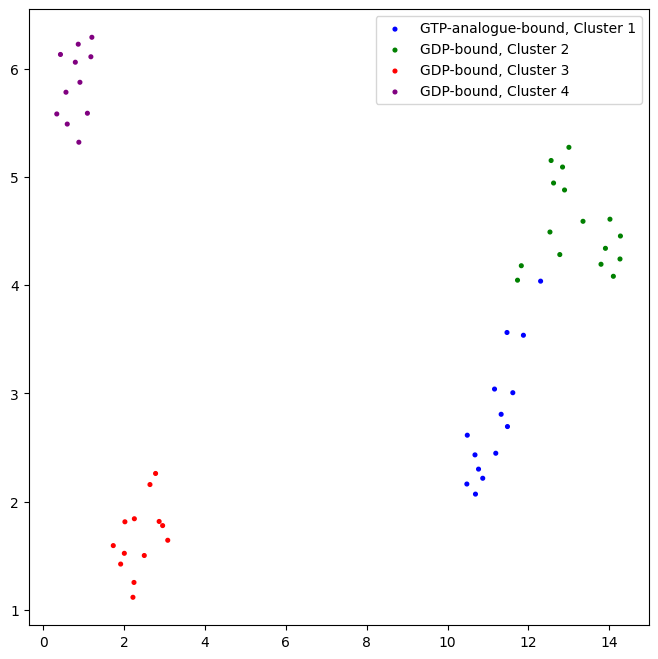

In [7]:
distance_matrix = A.get_GW_dmat()
reducer = UMAP(metric = 'precomputed', random_state=14)
embedding = reducer.fit_transform(distance_matrix)
    

group1 = [11, 34, 39, 40, 41, 42, 43, 44, 45, 46, 47] #purple
group2 = [4, 20,21,22,23,24,25,26,27,49,50,51,52] #red
group3 = [5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 30, 48, 53] #green
group4 = [0, 1, 2, 3, 19, 28, 29, 31, 32, 33, 35, 36, 37, 38] #blue


plt.figure(figsize=(8, 8))
plt.scatter([embedding[i, 0] for i in group4], [embedding[i, 1] for i in group4], c= ['blue']*14, s=7, label = "GTP-analogue-bound, Cluster 1")
plt.scatter([embedding[i, 0] for i in group3], [embedding[i, 1] for i in group3], c= ['green']*16, s=7, label = "GDP-bound, Cluster 2")
plt.scatter([embedding[i, 0] for i in group2], [embedding[i, 1] for i in group2], c= ['red']*13, s=7, label = "GDP-bound, Cluster 3")
plt.scatter([embedding[i, 0] for i in group1], [embedding[i, 1] for i in group1], c= ['purple']*11, s=7, label = "GDP-bound, Cluster 4")
plt.legend()

plt.show()


Using pymol we can clearly see that these clusters reflect conformational differences between the proteins. In this image of switch region II we see that the four clusters take have distinct conformations. We note that the blue and green proteins are very close by both conformationationally and in the UMAP clustering, corresponding to the fact that they have they have low GW distances. 


![Example_Data/Images/Switch_Region_II.png](Example_Data/Images/Switch_Region_II.png)

In this image of switch region I we see that most GTP-analogue-bound proteins (blue) have similar conformations and most GDP-bound proteins (red, green, and purple) have similar conformations distinct from the GTP-analogue-bound ones. 

![Example_Data/Images/Switch_Region_I.jpg](Example_Data/Images/Switch_Region_I.jpg)

Along with the different types of ligands, mutations, different drug candidates, and batch effects could contribute to the different conformations.

Next we use `pymol_protein_viewer.show_proteins_with_values` to visualize the proteins and the stress levels of different residues in the proteins. `A.raw_stress_levels` contains the stresses of all the pairwise calculations, so we first average them for each protein.

In [8]:
avg_stresses_dict =  stress_comparison.normalize_stress_dict( A.raw_stress_dict)
avg_stresses_list = [avg_stresses_dict[name] for name in A.name_list]

In [9]:
pymol_protein_viewer.show_proteins_with_values( infiles = [os.path.join(dir, file)  for file in os.listdir(dir)],     chain_ids = [ file[5]  for file in os.listdir(dir)],     data_lists = avg_stresses_list,     output_file = "Examples Data/Pymol Outputs/KRAS Stresses.pse")

pm created


The pymol file we generated and saved to `KRAS Stresses.pse`can then be opened in a Pymol GUI window. The switch I region is in the foreground at the upper left and the switch II region in the foreground right. We see that both have higher stress levels as indicated by the redder colors, whereas the non-switch regions have lower stress as indicated by yellows. 


![Example_Data/Images/KRAS_Stresses.png](Example_Data/Images/KRAS_Stresses.png)

Next we will test how well the stress levels can be used to predict the switch I and switch II regions. These regions do not have well-defined endpoints but we will choose to use residues 30-40 and 60-72 in the canonical indexing respectively. As these files do not contain all the residues the switch regions are at indices 28-38 and 58-74 instead. 

We display the precision-recall curve of a randomly selected protein and the mean average precision (area under precision-recall curve).

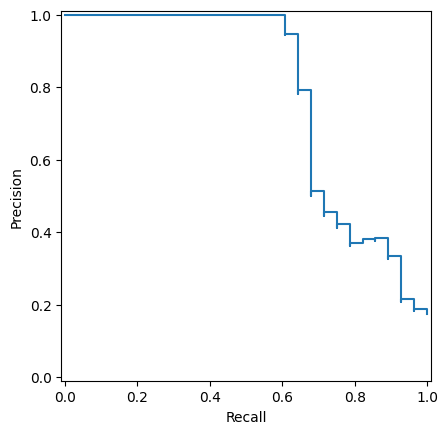

mean average precision = 0.8423611265528455


In [10]:
switch_regions_dict = {p.name : [ int(i in range(28,39) or i in range(58,75)) for i in range(161)] for p in protein_list}

p,r,_ = sklearn.metrics.precision_recall_curve(switch_regions_dict['5mla_A'],  avg_stresses_dict['5mla_A'])
sklearn.metrics.PrecisionRecallDisplay(precision = p, recall = r).plot()
plt.show()
avg_precision_dict = stress_comparison.get_AP_scores(avg_stresses_dict, switch_regions_dict, upper = True)

print(f'mean average precision = {np.mean(list(avg_precision_dict.values()))}')

We can also compute the transferred stresses with `raw_transferred_stresses` which we then need to average with `normal_stress_dict`. Transferring uses the calculated transport plans to transpose the stresses of one protein to another, and this is done in an all-to-all fashion. Generally this improves accuracy. This computation takes under a second here but aroung 18 second when `RAM = False` due to file I/O.

In [11]:
transferred_stresses = stress_comparison.normalize_stress_dict( A.raw_transferred_stresses(avg_stresses_dict))

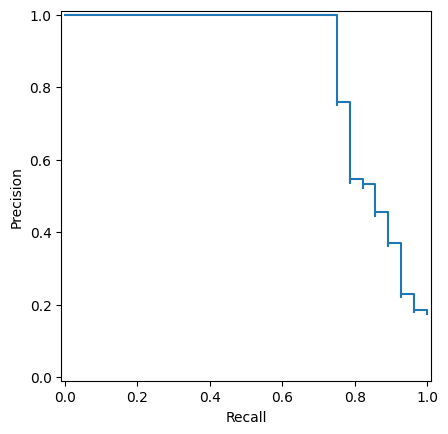

mean average precision = 0.8587374997410856


In [12]:
p,r,_ = sklearn.metrics.precision_recall_curve(switch_regions_dict['5mla_A'],  transferred_stresses['5mla_A'])
sklearn.metrics.PrecisionRecallDisplay(precision = p, recall = r).plot()
plt.show()

transferred_avg_precision_dict = stress_comparison.get_AP_scores(transferred_stresses, switch_regions_dict, upper = True)
print(f'mean average precision = {np.mean(list(transferred_avg_precision_dict.values()))}')